In [24]:
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
import numpy  as np
# sys.path.append('./pyperch')
# from pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import torch
import random
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, make_scorer, f1_score, confusion_matrix, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from pipelines import KMeans_pipeline, TSNE_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import helpers
import importlib
import pipelines
import pipeline_helpers
import seaborn as sns
from scipy.stats import kurtosis
from notebook_helper import reload_notebook_cell, generate_seed
from sklearn.model_selection import KFold
# import cross_validation
from sklearn.model_selection import cross_validate


## Get Data

In [25]:

from generate_data import get_and_preprocess_sdas_data, get_and_preprocess_raisin_data, y_label_encode, CATEGORY_COLUMNS_UCML
from sklearn.preprocessing import  LabelEncoder
reload_notebook_cell()

X_train_sdas, X_test_sdas, y_train_sdas, y_test_sdas = get_and_preprocess_sdas_data()
X_train_raisin, X_test_raisin, y_train_raisin, y_test_raisin = get_and_preprocess_raisin_data()

# Initialize and fit LabelEncoder
y_train_encoded_sdas, y_test_encoded_sdas, label_encoder_sdas = y_label_encode(y_train_sdas,y_test_sdas)
y_train_encode_raisin, y_test_encode_raisin, label_encoder_raisin = y_label_encode(y_train_raisin, y_test_raisin)

# get data to correct type for NN
y_train_encoded_sdas = y_train_encoded_sdas.astype(np.int64)
y_train_encode_raisin = y_train_encode_raisin.astype(np.int64)

cv = KFold(n_splits=4, shuffle=False)

c:\Users\WarrenKushner\Documents\ML\A3\generate_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X["Marital Status"]  != 1) & (X["Marital Status"] != 2) & (X["Marital Status"] != 4)]["Marital Status"] = -1


Removed columns: ["encoding__Mother's qualification_18", "encoding__Mother's qualification_44", "encoding__Father's qualification_18", "encoding__Father's occupation_161"]
Number of features after removal: 200


## Generate DR Pipelines with best parameters

GMM:
* Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 5}
* Min BIC score for SDAS: 310237.51832408167
* Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 3}
* Min BIC score for Raisin: 54.834866983856514

KMeans:
* Max  silhouette score for SDAS data: 0.27221161231984853 at k=2
* Max  silhouette score for Raisin data: 0.6354626224926063 at k=2

In [44]:
reload_notebook_cell()
best_kmeans_raisin = {"n_clusters": 2, "random_state":42 }
best_gaussian_raisin = {"n_components": 3, "covariance_type": 'full',"random_state":42 }
best_net_inputs_raisin =   {
    "module__hidden_units": 25,
    "module__hidden_layers": 1,
    "module__activation": torch.nn.ReLU(),
    "optimizer__lr": 0.0025,
    "max_epochs": 170, # 88 for raisin
    "module__input_dim": 7,
    "module__output_dim": 2,

}

## raisin Kmeans
best_net_inputs_raisin["module__input_dim"]+=2
net_kmeans_raisin_pipeline = pipelines.NN_pipeline_with_clustering(X_train_raisin, [],  best_net_inputs_raisin, best_kmeans_raisin, cluster_method='kmeans')
best_net_inputs_raisin["module__input_dim"]=7+3 # reset to original value and add 3
net_gmm_raisin_pipeline = pipelines.NN_pipeline_with_clustering(X_train_raisin, [],  best_net_inputs_raisin, best_gaussian_raisin, cluster_method='gmm')


# pipeline_Kmeans_Raisin = pipelines.PCANoStandard_pipeline(X_train_raisin, y_train_encode_raisin,  **best_pca_raisin)
# pipeline_RP_Raisin = pipelines.GaussianRPNoStandard_pipeline(X_train_raisin, y_train_encode_raisin,  **best_rp_raisin)
# pipeline_ICA_Raisin = pipelines.ICA_pipeline(X_train_raisin, y_train_encode_raisin, **best_ica_raisin)







cpu
cpu


## Loss Curves

In [45]:
reload_notebook_cell()
# Function to get loss curves and find the best epoch
# Function to get average training history per epoch



# Run the models and capture loss curves
# Get average histories for each model
avg_train_loss_kmeans, avg_val_loss_kmeans = pipeline_helpers.run_and_get_avg_history(net_kmeans_raisin_pipeline, X_train_raisin, y_train_encode_raisin)
avg_train_loss_gmm, avg_val_loss_gmm = pipeline_helpers.run_and_get_avg_history(net_gmm_raisin_pipeline, X_train_raisin, y_train_encode_raisin)
# avg_train_loss_ica, avg_val_loss_ica = pipeline_helpers.run_and_get_avg_history(net_pipeline_ica, X_train_raisin, y_train_encode_raisin)
# avg_train_loss_orginal, avg_val_loss_orginal = pipeline_helpers.run_and_get_avg_history(net_pipeline_orginal, X_train_raisin, y_train_encode_raisin)

# Find the best epoch
best_epoch_kmeans = np.argmin(avg_val_loss_kmeans) + 1
best_epoch_gmm = np.argmin(avg_val_loss_gmm) + 1



{'KMeans': 57, 'GMM': 41} 170


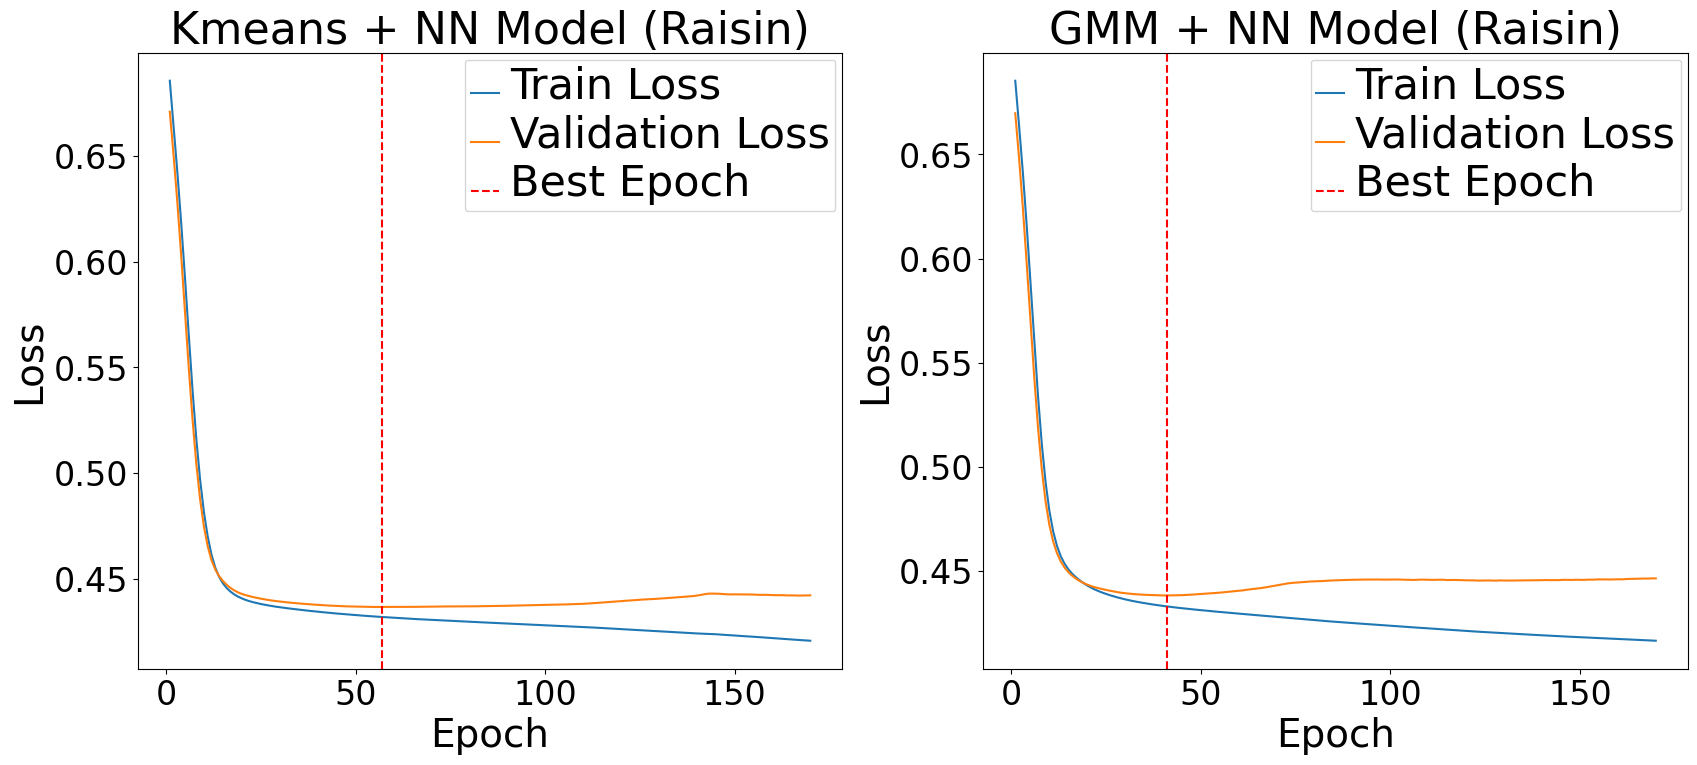

In [58]:
# Plot the loss curves in subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Kmeans subplot
x_range = range(1, len(avg_train_loss_kmeans) + 1)
axs[0].plot(x_range,avg_train_loss_kmeans, label='Train Loss')# thickiness of the line (linewidth=2
axs[0].plot(x_range,avg_val_loss_kmeans, label='Validation Loss')
axs[0].axvline(x=best_epoch_kmeans, color='r', linestyle='--', label='Best Epoch')
axs[0].set_title('Kmeans + NN Model (Raisin)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

x_range = range(1, len(avg_train_loss_gmm) + 1)
# GMM subplot
axs[1].plot(x_range, avg_train_loss_gmm, label='Train Loss')
axs[1].plot(x_range, avg_val_loss_gmm, label='Validation Loss')
axs[1].axvline(x=best_epoch_gmm, color='r', linestyle='--', label='Best Epoch')
axs[1].set_title('GMM + NN Model (Raisin)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()


best_epochs = {
    'KMeans': best_epoch_kmeans,
    'GMM': best_epoch_gmm
}

helpers.increase_font_size_subplots_included(plt, constant=2)
print(best_epochs, len(avg_train_loss_kmeans))

### reparameterize NN pipeliens with best epoch

In [47]:
reload_notebook_cell()

## raisin Kmeans
best_net_inputs_raisin["module__input_dim"] = 9
best_net_inputs_raisin["max_epochs"] = best_epochs['KMeans']
net_kmeans_raisin_pipeline = pipelines.NN_pipeline_with_clustering(X_train_raisin, [],  best_net_inputs_raisin, best_kmeans_raisin, cluster_method='kmeans')

# raisin GMM
best_net_inputs_raisin["module__input_dim"]=10
best_net_inputs_raisin["max_epochs"] = best_epochs['GMM']
net_gmm_raisin_pipeline = pipelines.NN_pipeline_with_clustering(X_train_raisin, [],  best_net_inputs_raisin, best_gaussian_raisin, cluster_method='gmm')

cpu
cpu


In [48]:

reload_notebook_cell()
# perform cross validation
scores_kmeans = cross_validate( 
               net_kmeans_raisin_pipeline, 
               X_train_raisin, 
               y_train_encode_raisin, 
               cv=cv, 
               return_train_score=True, 
               scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score), 'log_loss': make_scorer(log_loss)}, n_jobs=1)

scores_gmm = cross_validate( 
                net_gmm_raisin_pipeline, 
                X_train_raisin, 
                y_train_encode_raisin, 
                cv=cv, 
                return_train_score=True, 
                scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score), 'log_loss': make_scorer(log_loss)},  n_jobs=1)


In [49]:
import pandas as pd
# Example cross-validation results dictionaries for other methods


# Convert to DataFrames
df_scores_kmeans = pd.DataFrame(scores_kmeans)
df_scores_gmm = pd.DataFrame(scores_gmm)
# Rename columns
df_scores_kmeans.rename(columns={'test_accuracy': 'validation_accuracy', 'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_gmm.rename(columns={'test_accuracy': 'validation_accuracy', 'test_log_loss': 'validation_log_loss'}, inplace=True)


# Drop F1 columns
df_scores_gmm.drop(columns=['test_f1', 'train_f1'], inplace=True)
df_scores_kmeans.drop(columns=['test_f1', 'train_f1'], inplace=True)


# Add method names
df_scores_kmeans['method'] = 'KMeans'
df_scores_gmm['method'] = 'GMM'

# Combine all DataFrames
df_all_scores = pd.concat([ df_scores_kmeans, df_scores_gmm], ignore_index=True)
df_avg_scores = df_all_scores.groupby('method').mean().reset_index()
df_avg_scores

,method,fit_time,score_time,validation_accuracy,train_accuracy,validation_log_loss,train_log_loss
0,GMM,1.139002,0.011727,0.880556,0.881019,4.305214,4.288527
1,KMeans,1.323058,0.018445,0.877778,0.883333,4.405335,4.205093


## See How each model performs on the test set

In [50]:
import copy
reload_notebook_cell()
best_net_inputs_raisin["max_epochs"] = best_epoch_kmeans

best_net_inputs_raisin["module__input_dim"] = 9
net_pipeline_kmeans = pipelines.NN_pipeline_with_clustering(X_train_raisin, [],  best_net_inputs_raisin, best_kmeans_raisin, cluster_method='kmeans')
# adjust for RP
best_net_inputs_raisin  = copy.deepcopy(best_net_inputs_raisin)
best_net_inputs_raisin["module__input_dim"] = 10
best_net_inputs_raisin["max_epochs"] = best_epoch_gmm
net_pipeline_gmm = pipelines.NN_pipeline_with_clustering(X_train_raisin, [],  best_net_inputs_raisin, best_gaussian_raisin, cluster_method='gmm')



cpu
cpu


In [51]:
reload_notebook_cell()
net_pipeline_kmeans.fit(X_train_raisin, y_train_encode_raisin)
net_pipeline_gmm.fit(X_train_raisin, y_train_encode_raisin)


NN(steps=[('preprocessor',
           ColumnTransformer(remainder='passthrough',
                             transformers=[('num', StandardScaler(),
                                            ['MajorAxisLength', 'ConvexArea',
                                             'Area', 'Perimeter',
                                             'MinorAxisLength', 'Eccentricity',
                                             'Extent'])])),
          ('cluster_and_encode',
           ClusterAndEncode(clusterer=GaussianMixture(n_components=3,
                                                      random_state=42))),
          ('classifier',
           <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CustomBackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=25, bias=True)
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))])

In [52]:
reload_notebook_cell()
## evaluate accuracy and log loss of the models on test 
y_pred_kmeans = net_pipeline_kmeans.predict(X_test_raisin)
y_pred_gmm = net_pipeline_gmm.predict(X_test_raisin)


accuracy_kmeans = accuracy_score(y_test_encode_raisin, y_pred_kmeans)
accuracy_gmm = accuracy_score(y_test_encode_raisin, y_pred_gmm)


log_loss_kmeans = log_loss(y_test_encode_raisin, net_pipeline_kmeans.predict_proba(X_test_raisin))
log_loss_gmm = log_loss(y_test_encode_raisin, net_pipeline_gmm.predict_proba(X_test_raisin))


print(f'Accuracy Kmeans: {accuracy_kmeans:.4f}, Log Loss Kmeans: {log_loss_kmeans:.4f}')
print(f'Accuracy GMM: {accuracy_gmm:.4f}, Log Loss Gmm: {log_loss_gmm:.4f}')

df_avg_scores['test_accuracy'] = [accuracy_gmm, accuracy_kmeans]
df_avg_scores['test_log_loss'] = [log_loss_gmm, log_loss_kmeans]
df_avg_scores["best_epoch"] = [best_epoch_gmm, best_epoch_kmeans]

df_avg_scores

Accuracy Kmeans: 0.8611, Log Loss Kmeans: 0.4487
Accuracy GMM: 0.8611, Log Loss Gmm: 0.4500


,method,fit_time,score_time,validation_accuracy,train_accuracy,validation_log_loss,train_log_loss,test_accuracy,test_log_loss,best_epoch
0,GMM,1.139002,0.011727,0.880556,0.881019,4.305214,4.288527,0.861111,0.449999,41
1,KMeans,1.323058,0.018445,0.877778,0.883333,4.405335,4.205093,0.861111,0.448687,57


In [55]:
df_avg_scores["fit_time"]/df_avg_scores["best_epoch"]

0    0.027781
1    0.023212
dtype: float64

In [56]:
df_avg_scores["score_time"]/df_avg_scores["best_epoch"]

0    0.000286
1    0.000324
dtype: float64

NameError: name 'net_pipeline_orginal' is not defined